In [50]:
# Imports
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
from setup import *
from ipywidgets import *
import file_open
import math
print(matplotlib.get_backend())
style = {'description_width': 'initial'}

nbAgg


# Image upload
This notebook processes photos of mayfly eggs and uses blob detection to count the number of eggs in the image. Run the cell below and select a single file to process. The image is converted to greyscale automatically upon uploading. The axes show the image size in pixels to help us select the appropriate size thresholds when setting upi the blob detection algorithm.

<IPython.core.display.Javascript object>


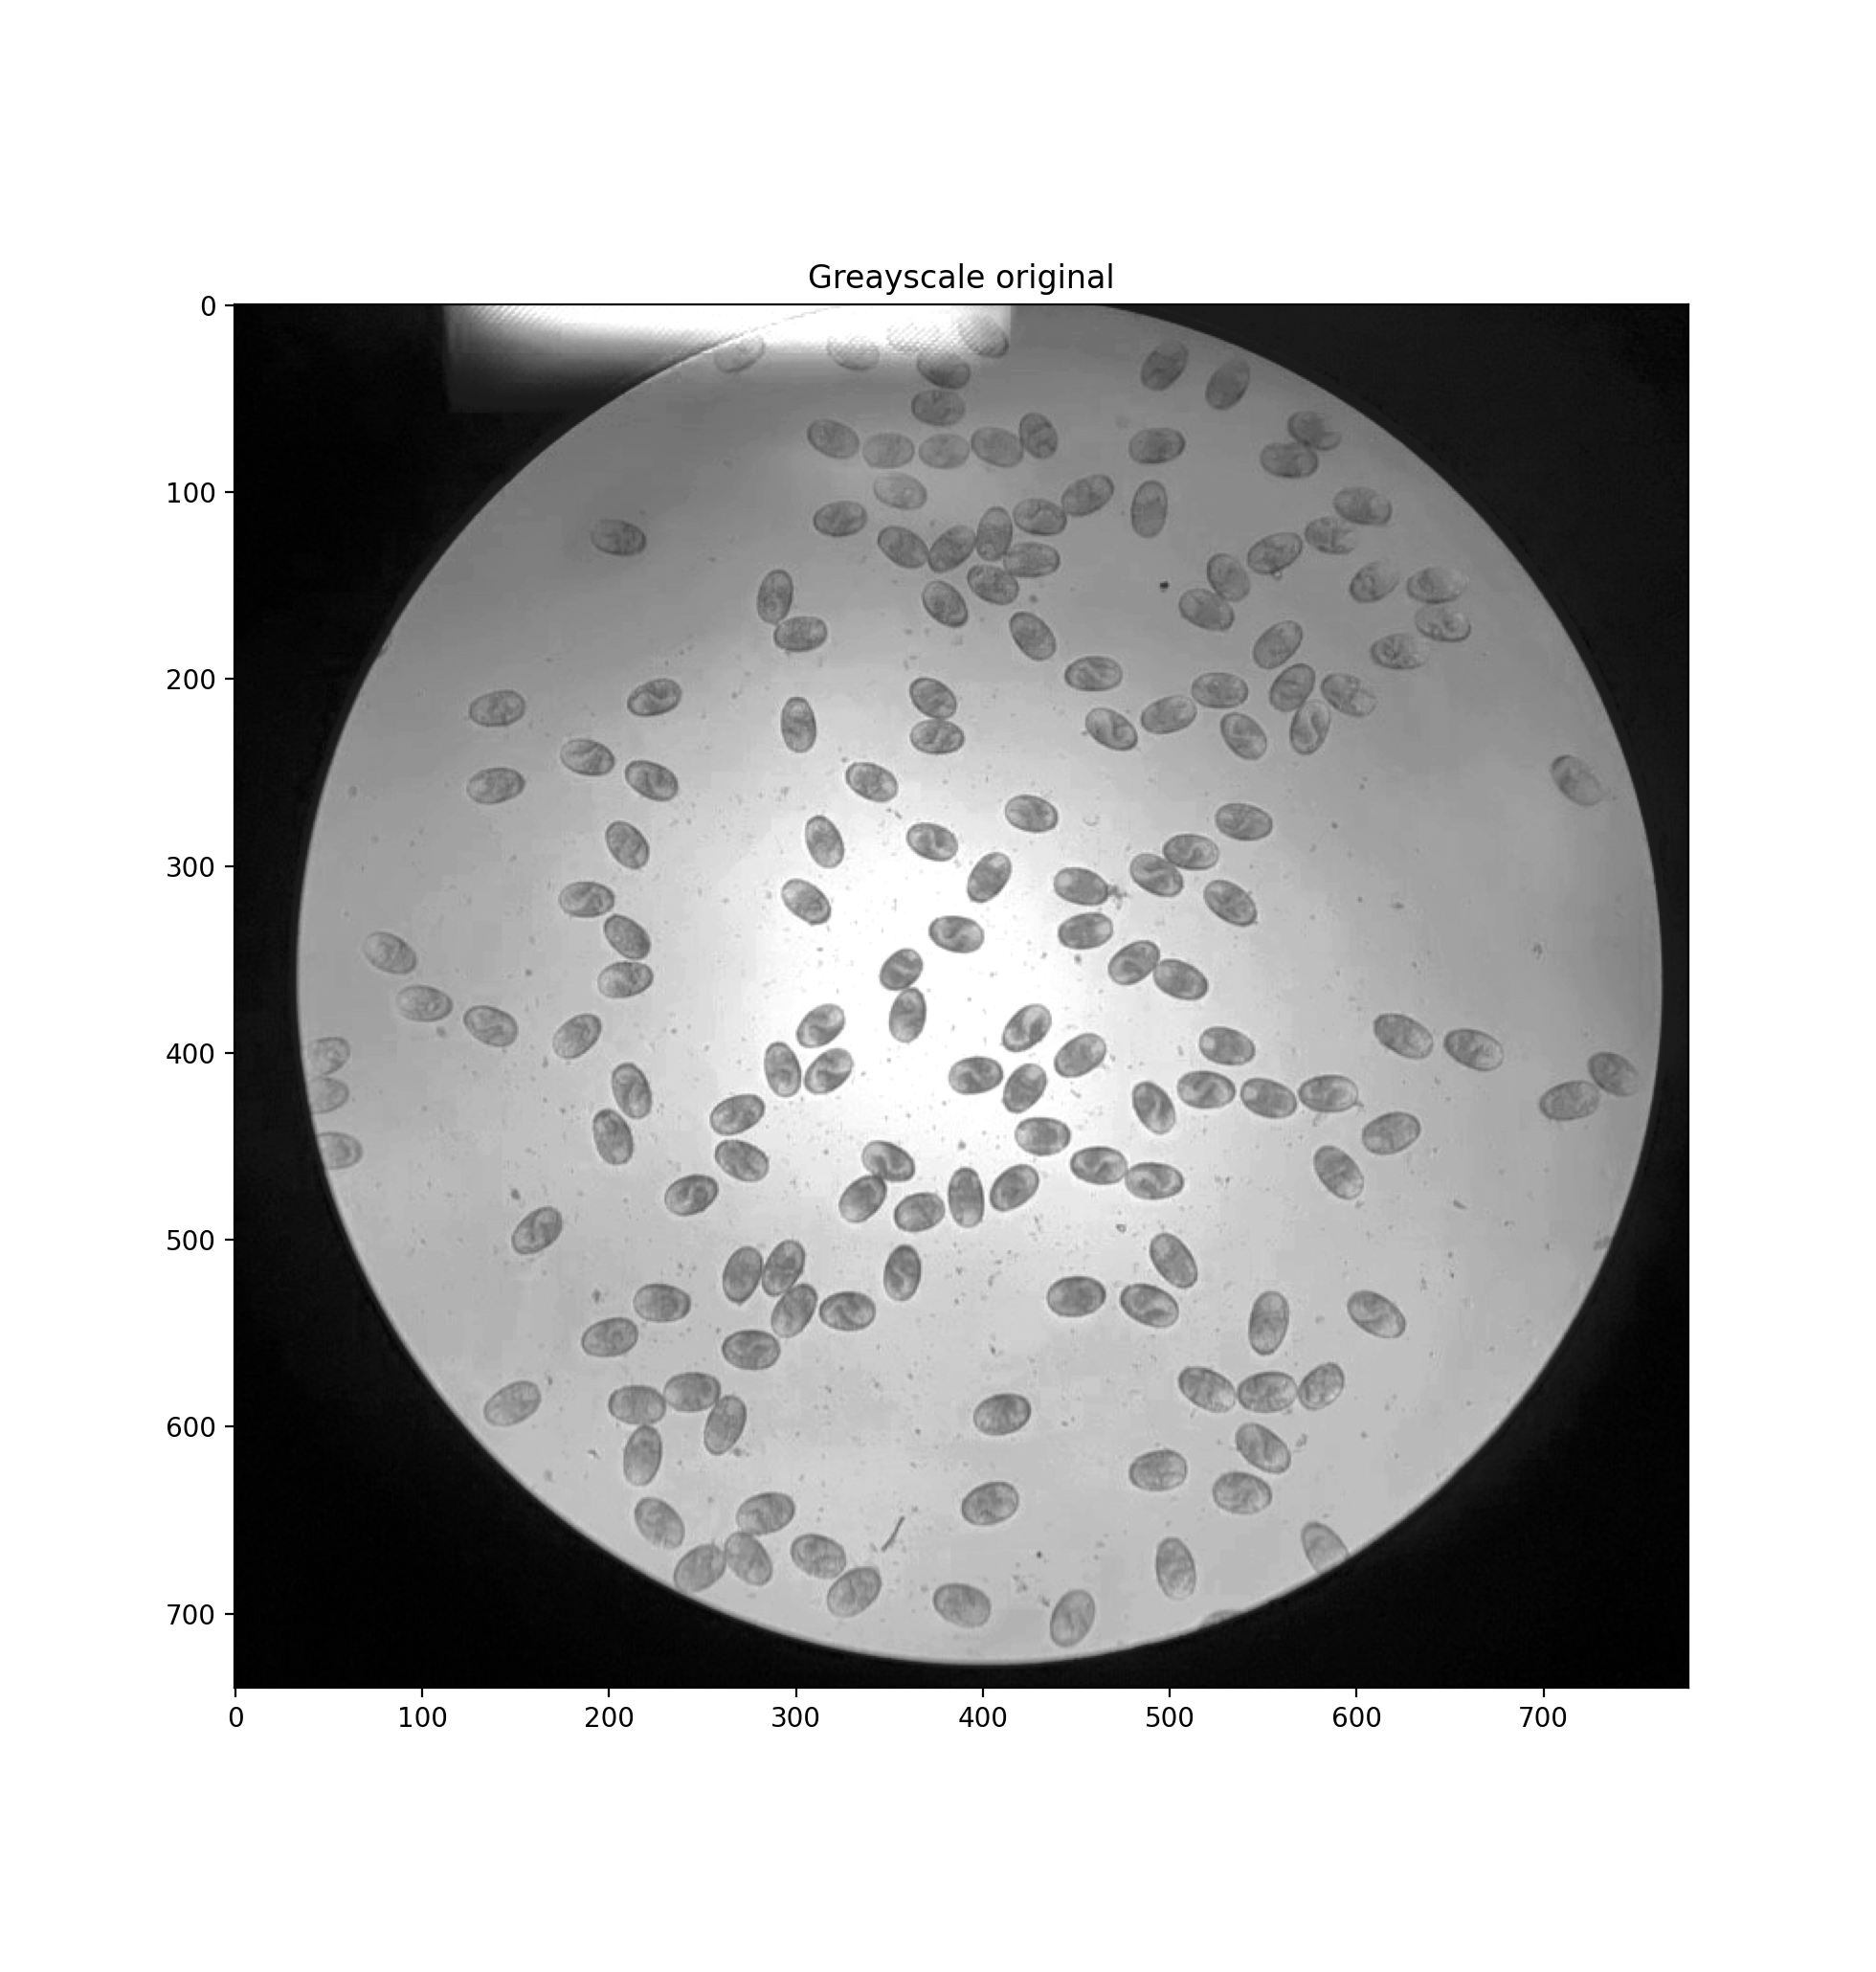

In [348]:
fileName = file_open.gui_fname()
im = cv2.imread(fileName.decode("utf-8"), cv2.IMREAD_GRAYSCALE)
h, w = im.shape
aspect_ratio = h/w + 0.1
width = 9.8
fig = plt.figure(figsize=(width,width*aspect_ratio))
plt.subplot(111)
plt.imshow(im, cmap='gray')
plt.title('Greayscale original')
# plt.axis('off')
plt.show()
original = im

# Image thresholding
Firstly, we try to remove all unncesary image artifacts by thresholding the values of each pixel along the greyscale. We will try two types of thresholding: global and adaptive one. In global thresholding, the same threshold value is applied to every pixel in the image. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value that we define. In the adaptive thresholding, the threshold for each pixel is determined by the small region around it. The first type of thresholding is suitable for images where the lighting is uniform and there are no overexposed areas. The adaptive type is useful for images where the brightness is not uniform. 

<IPython.core.display.Javascript object>


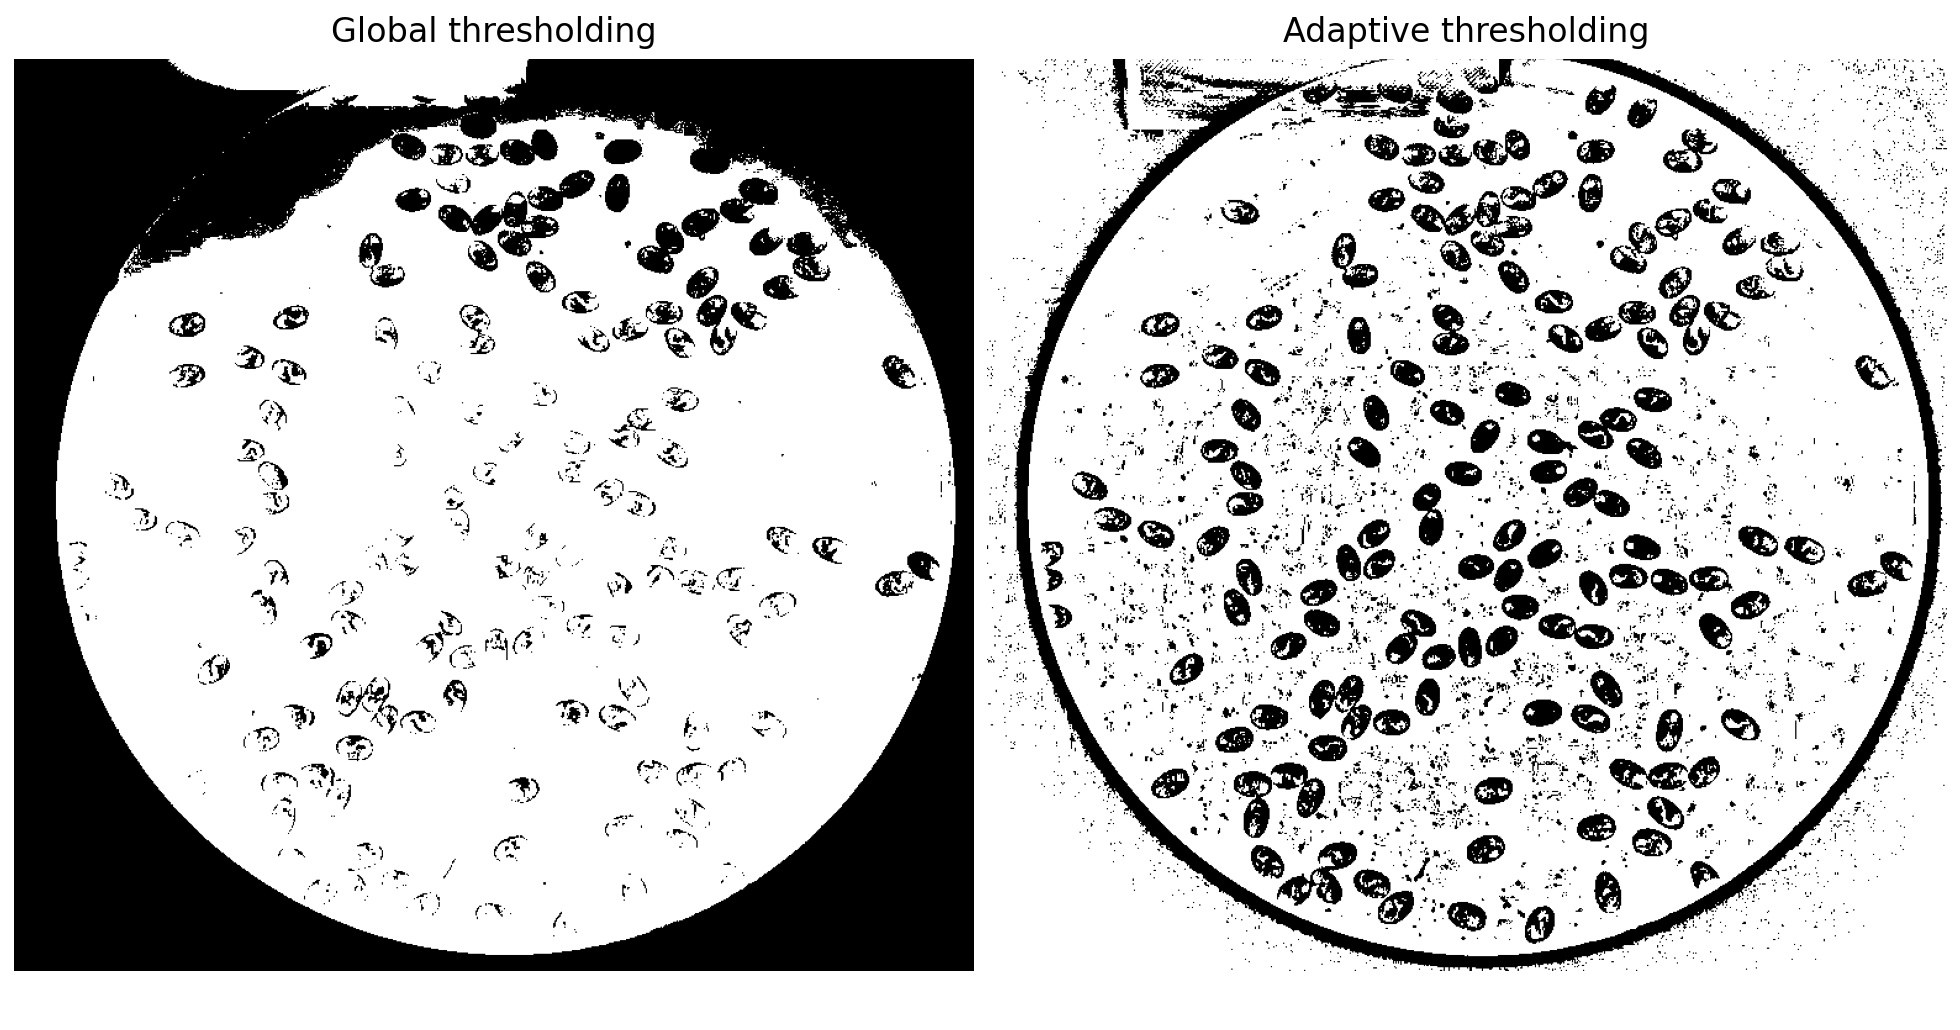

interactive(children=(IntSlider(value=127, description='Global threshold', max=254, min=1, style=SliderStyle(d…

In [375]:
thresholdGlobal = 127
pixelNeigbourhood = 11
constant = 4
ret, thresh_global = cv2.threshold(original,thresh=thresholdGlobal,maxval=255,type=cv2.THRESH_BINARY)
thresh_adapt = cv2.adaptiveThreshold(original, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv2.THRESH_BINARY, blockSize=pixelNeigbourhood, C=constant)
# plot
numCols, numRows = 2, 1
fig, axes = plt.subplots(numRows,numCols, figsize=((width,width*aspect_ratio*numRows/numCols)))
plotter_thresh_g = axes[0].imshow(thresh_global, cmap='gray')
axes[0].set_title('Global thresholding')
axes[0].axis('off')
plotter_thresh_a = axes[1].imshow(thresh_adapt, cmap='gray')
axes[1].set_title('Adaptive thresholding')
axes[1].axis('off')
plt.tight_layout(pad=0.5)
plt.show()
# interactive part
def update_morphology(threshold_upd,block_upd,const_upd):
    ret,thresh_global = cv2.threshold(original,thresh=threshold_upd,maxval=255,type=cv2.THRESH_BINARY)
    thresh_adapt = cv2.adaptiveThreshold(original, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv2.THRESH_BINARY, blockSize=block_upd, C=const_upd)
    plotter_thresh_g.set_data(thresh_global)
    plotter_thresh_a.set_data(thresh_adapt)
    fig.canvas.draw_idle()
# sliders
thr_slider0 =  widgets.IntSlider(min=1, max=254, step=1, value=thresholdGlobal, description='Global threshold',style=style) 
thr_slider1 =  widgets.IntSlider(min=3, max=200, step=1, value=pixelNeigbourhood, description='Neighbourhood area',style=style) 
thr_slider2 = widgets.IntSlider(min=1, max=100, step=1, value=constant, description='Constant',style=style)
interact(update_morphology,threshold_upd=thr_slider0, block_upd=thr_slider1,const_upd=thr_slider2);

## After the thresholding is done, select the image for which you see most egg shapes intact.

In [376]:
list_of_images = [original, thresh_global, blob_global]
list_of_titles = ['Original','Global threholding', 'Adaptive thresholding']
checkboxes = [widgets.Checkbox(value=False, description=label) for label in list_of_titles]
output = widgets.VBox(children=checkboxes)
display(output)

## Run the cell below whenever you select or de-select a checkbox in the list above!

In [404]:
    selected_images = []
    selected_titles = []
    for i in range(0, len(checkboxes)):
        if checkboxes[i].value == True:
            selected_titles = selected_titles + [checkboxes[i].description]
            selected_images.append(list_of_images[i])
    print(selected_titles)

['Adaptive thresholding']


## Check the box below if the blobs are white on the black background (keep unchecked otherwise)

In [424]:
blobsAreWhite = False
def checkbox_state(checked):
    global blobsAreWhite 
    blobsAreWhite = checked
    print("Blobs are white? ", blobsAreWhite)

checkbox = widgets.Checkbox(description='Checkbox')
interact(checkbox_state, checked=checkbox);

interactive(children=(Checkbox(value=False, description='Checkbox'), Output()), _dom_classes=('widget-interact…

# Morphological transforms
Simple thresholding does not remove all noise artifacts from the image and the standard smoothing methods for images may not work because the eggs are close to one another on some images an with smoothing their overlap will increase. Instead of standard denoising methods, we can transform the image by convolving it with a kernel - a square matrix of odd size (can take values above 3). In the erosion process, a pixel of the image is set to 1 if all pixels in the kernel surrounding it are also 1. Otherwise, it is set to 0. In the dilation process, the opposite procedure takes place. The process of openning removes background inperfections and constitutes erosion followed by dilation. The process of closing entails first dialating and then eroding the image to reduce the noise inside the blobs. Note that the process will depend on the contrast of the original image, namely if the blobs are white on the black back ground or vice versa. 

True


<IPython.core.display.Javascript object>


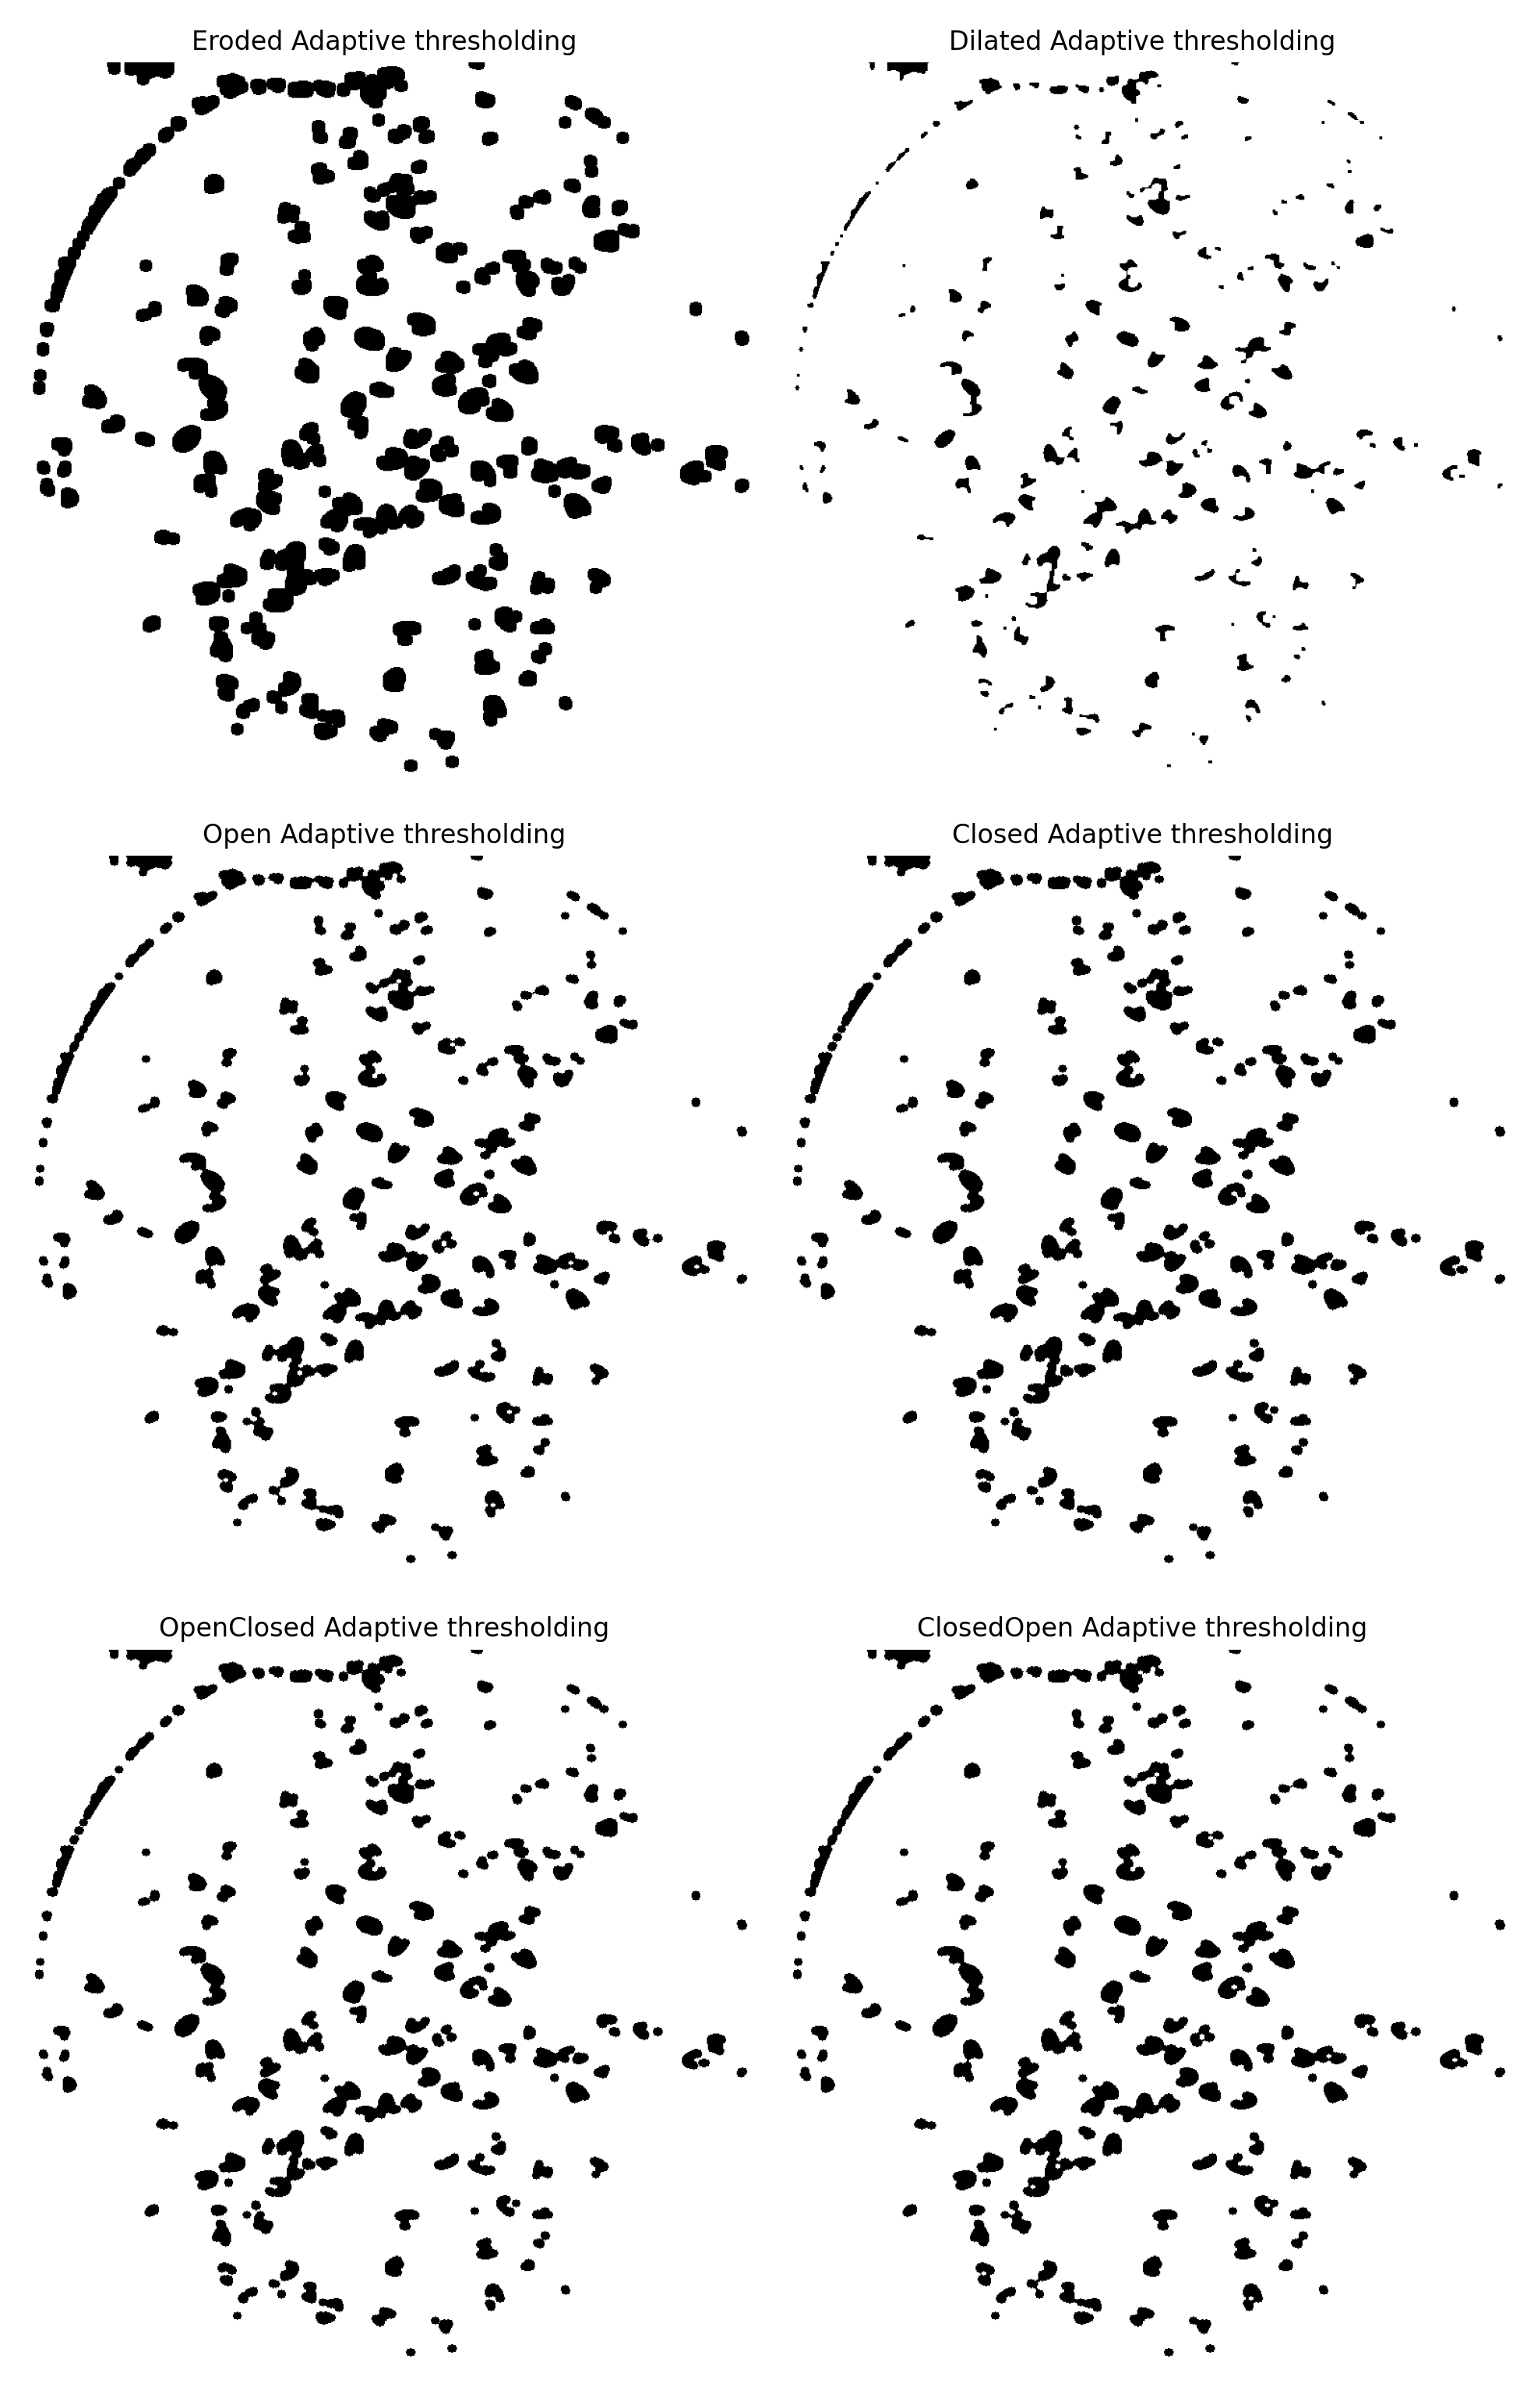

interactive(children=(IntSlider(value=5, description='Erosion kernel size', max=55, min=3, step=2, style=Slide…

In [425]:
# apply morphology open then close to both thresholded images
transform_titles = ['Eroded','Dilated','Open','Closed','OpenClosed','ClosedOpen']
openSize = 5
closeSize = 9
erodeSize = 5
dilateSize = 5
kernelErode = np.ones((erodeSize, erodeSize), np.uint8)
kernelDilate = np.ones((dilateSize, dilateSize), np.uint8)
kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (openSize,openSize))
kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (closeSize,closeSize))
# apply kernels to all images in selected list
numRows = math.ceil(len(transform_titles)*len(selected_images)/2)
numCols = max(len(selected_images),2)
fig_eroded, axes =  plt.subplots(numRows, numCols, figsize=(width,width*aspect_ratio*numRows/numCols))
plt.ion()
# plot looping over the images that were selected above and stored into the list
plotters = []
morph_images = []
morph_titles = []
for iImage, image in enumerate(selected_images):
    erodeBlob = cv2.erode(image, kernelErode, iterations=1)
    dilateBlob = cv2.dilate(image, kernelDilate, iterations=1)
    openBlob = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernelOpen)
    openCloseBlob = cv2.morphologyEx(openBlob, cv2.MORPH_CLOSE, kernelClose)
    closeBlob = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelClose)
    closeOpenBlob = cv2.morphologyEx(closeBlob, cv2.MORPH_OPEN, kernelOpen)
    list_aux = [erodeBlob, dilateBlob, openBlob, closeBlob, openCloseBlob, closeOpenBlob]
    for iRow in range(len(transform_titles)):
        if len(selected_images) > 1:
            ax = axes[iRow,iImage]
        else:
            ax = axes.flatten()[iRow]
        plotters.append(ax.imshow(list_aux[iRow], cmap='gray'))
        morph_images.append(list_aux[iRow])
        morph_titles.append(transform_titles[iRow] + ' ' + selected_titles[iImage])
        ax.set_title(transform_titles[iRow] + ' ' + selected_titles[iImage])
        ax.axis('off')
# if iImage < numRows*2:
#     for iEmptyImage in range(iImage+1,numRows*2):
#         ax = axes.flatten()[iEmptyImage]
#         fig.delaxes(ax)
plt.tight_layout(pad=0.5)
plt.show()    

# interactive part
def update_morphology(erodeSize_upd,dilateSize_upd,openSize_upd,closeSize_upd):
    kernelErode = np.ones((erodeSize_upd, erodeSize_upd), np.uint8)
    kernelDilate = np.ones((dilateSize_upd, dilateSize_upd), np.uint8)
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (openSize_upd,openSize_upd))
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (closeSize_upd,closeSize_upd))
    iCount = 0
    for iImage, image in enumerate(selected_images):
        erodeBlob = cv2.erode(image, kernelErode, iterations=1)
        dilateBlob = cv2.dilate(image, kernelDilate, iterations=1)
        openBlob = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernelOpen)
        openCloseBlob = cv2.morphologyEx(openBlob, cv2.MORPH_CLOSE, kernelClose)
        closeBlob = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelClose)
        closeOpenBlob = cv2.morphologyEx(closeBlob, cv2.MORPH_OPEN, kernelOpen)
        list_aux = [erodeBlob, dilateBlob, openBlob, closeBlob, openCloseBlob, closeOpenBlob] 
        for iRow in range(len(transform_titles)):
            if len(selected_images) > 1:
                ax = axes[iRow,iImage]
            else:
                ax = axes.flatten()[iRow]
            morph_images[iCount] = list_aux[iRow]
            plotters[iCount].set_data(list_aux[iRow])
            iCount += 1
            ax.axis('off')
    fig.canvas.draw_idle()
# sliders
e_slider =  widgets.IntSlider(min=3, max=55, step=2, value=erodeSize, description='Erosion kernel size',style=style) 
d_slider = widgets.IntSlider(min=3, max=55, step=2, value=dilateSize, description='Dilation kernel size',style=style)
o_slider =  widgets.IntSlider(min=3, max=55, step=2, value=openSize, description='Open kernel size',style=style) 
c_slider = widgets.IntSlider(min=3, max=55, step=2, value=closeSize, description='Close kernel size',style=style)
interact(update_morphology,erodeSize_upd=e_slider,dilateSize_upd=d_slider,openSize_upd=o_slider,closeSize_upd=c_slider);

In [406]:
checkboxes1 = [widgets.Checkbox(value=False, description=label) for label in morph_titles]
output = widgets.VBox(children=checkboxes1)
display(output)

## Run the cell below whenever you select or de-select a checkbox in the list above!

In [407]:
    selected_images1 = []
    selected_titles1 = []
    for i in range(0, len(checkboxes1)):
        if checkboxes1[i].value == True:
            selected_titles1 = selected_titles1 + [checkboxes1[i].description]
            selected_images1.append(morph_images[i])
    print(selected_titles1)

['Dilated Adaptive thresholding', 'OpenClosed Adaptive thresholding', 'ClosedOpen Adaptive thresholding']


# Erode the results once again for the good measure.

<IPython.core.display.Javascript object>


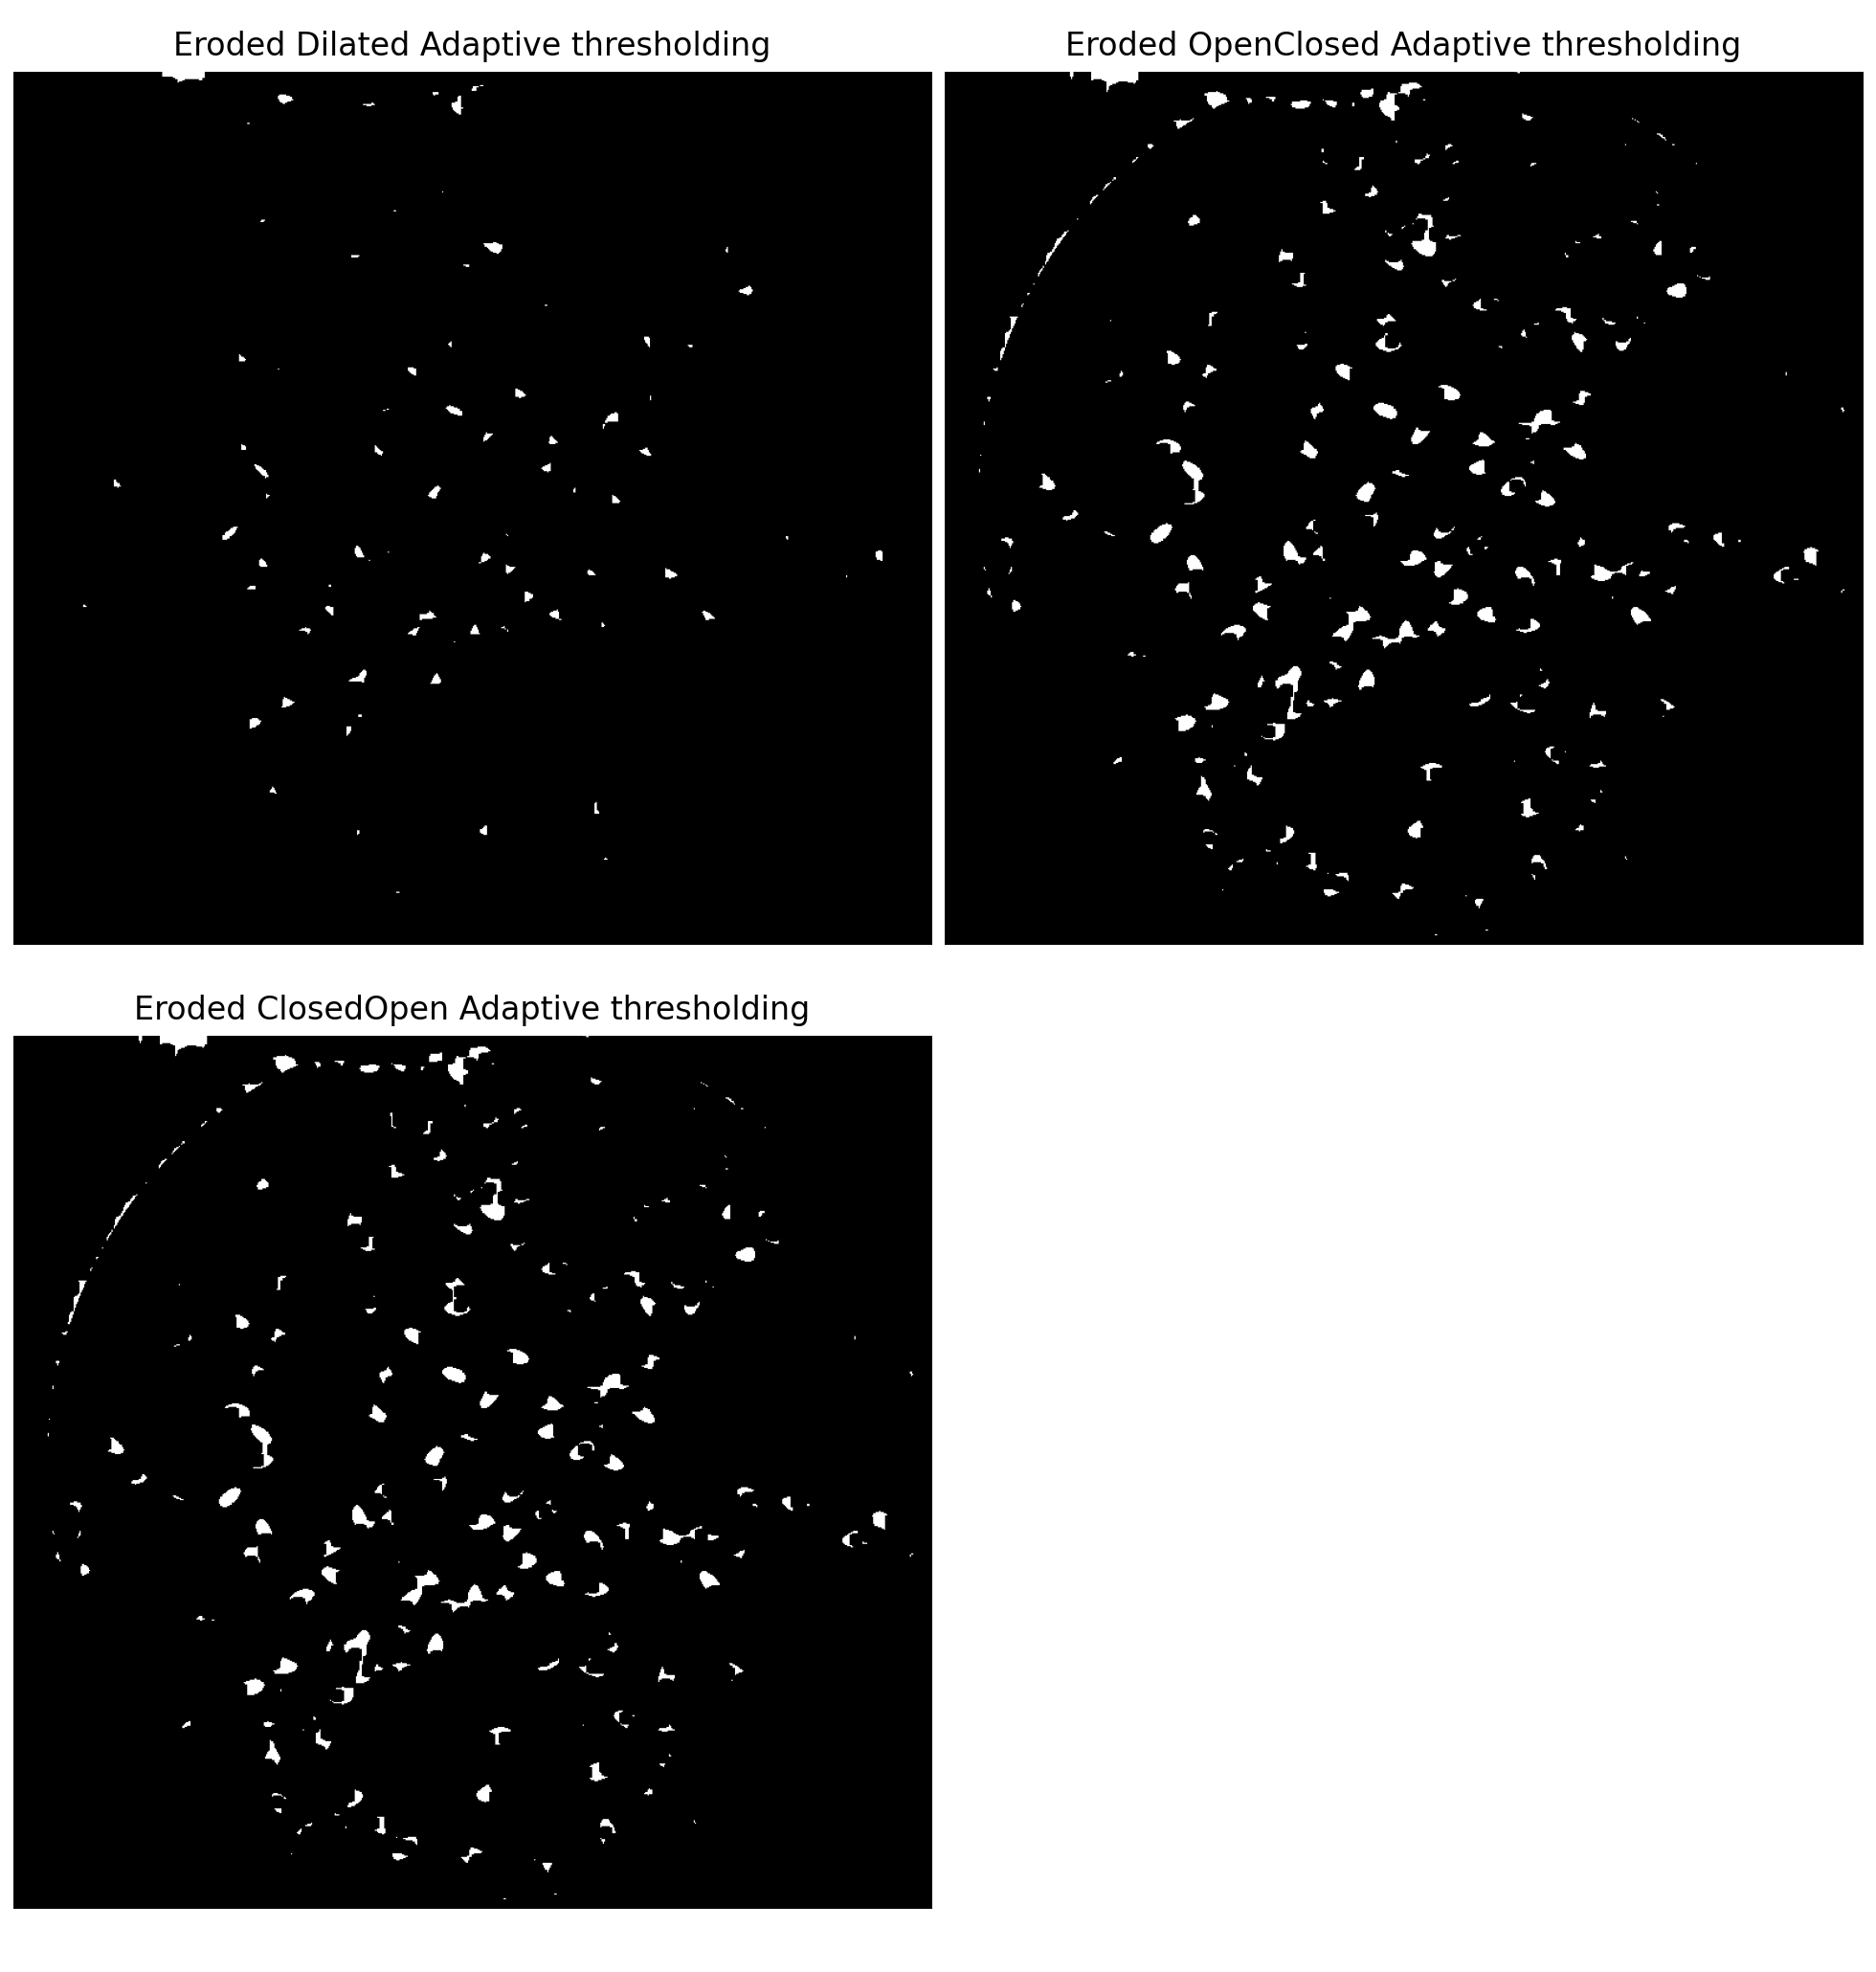

interactive(children=(IntSlider(value=5, description='Kernel size', max=35, min=3, step=2, style=SliderStyle(d…

In [430]:
# initial kernel size
initSize = 5
# create kernel
kernel = np.ones((initSize, initSize), np.uint8)
# erode images from the list of images selected above
numCols = 2
numRows = math.ceil(len(list_of_images)/numCols)
fig, axes =  plt.subplots(numRows, numCols, figsize=(width,width*aspect_ratio*numRows/numCols))
plt.ion()
#  loop over the images that were selected above and stored into the list
plotters = []
eroded_titles = []
eroded_images = []
for iImage, image in enumerate(selected_images1):
    if not blobsAreWhite:
        image = 255-image # if blobs are not white, invert colours
    eroded_titles.append('Eroded ' + selected_titles1[iImage])
    ax = axes.flatten()[iImage]
    im_eroded = cv2.erode(image, kernel, iterations=1)
    eroded_images.append(im_eroded)
    plotters.append(ax.imshow(im_eroded, cmap='gray'))
    ax.set_title(eroded_titles[iImage])
    ax.axis('off')
if iImage < numRows*2:
    for iEmptyImage in range(iImage+1,numRows*2):
        ax = axes.flatten()[iEmptyImage]
        fig.delaxes(ax)
plt.tight_layout(pad=0.5)
plt.show()    

def update_erode(KernelSize):
    #  update the kernel and run the erosion  
    kernel = np.ones((KernelSize, KernelSize), np.uint8)
    for iImage, image in enumerate(selected_images1):
        ax = axes.flatten()[iImage]
        if not blobsAreWhite:
            image = 255-image # if blobs are not white, invert colours
        im_eroded = cv2.erode(image, kernel, iterations=1)
        eroded_images[iImage] = im_eroded
        plotters[iImage].set_data(im_eroded)
    fig.canvas.draw_idle()
interact(update_erode, KernelSize=widgets.IntSlider(min=3,max=35,step=2,value=initSize, description='Kernel size',style=style));

# Blob detection
Create a detector with the set of parameters. This is the part where we do most of the parameter tuning. We will be usingseveral features of the "blobs" (the eggs) to threshold them from other image artifacts: area size, circularity, convexity, inertia, and color. The image should help to navigate these features. In the image, the values of all features of interes increase from left to right. For example, the colour values closer to 0 represent lighter shades of grey, and values closer to 255 darker shade.
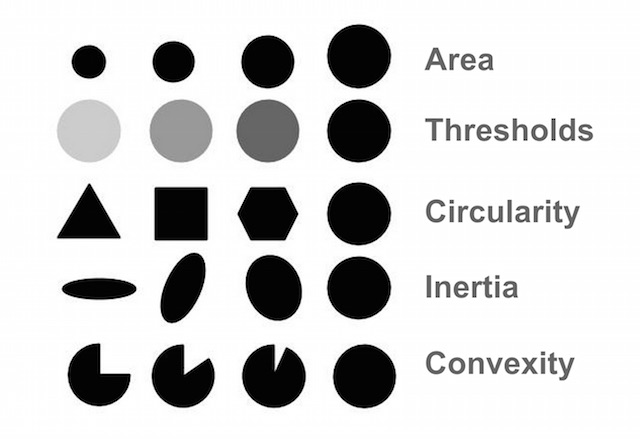
By default the thresholding in this detection algorithm is done by colour. You can select other filters for thresholding in the cell below.

In [431]:
# Set up the detector with default parameters:
detector = cv2.SimpleBlobDetector()
# Setup SimpleBlobDetector parameters
list_of_filters = ['Filter by area','Filter by circularity', 'Filter by convexity', 'Filter by inertia']
checkboxes2 = [widgets.Checkbox(value=False, description=label) for label in list_of_filters]
output = widgets.VBox(children=checkboxes2)
display(output)

In the cell below you can change the detector parameter values for each filter. 
## You will have to re-run the cell below every time you change any of the values!

Filters on:
[True, True, True, False]


<IPython.core.display.Javascript object>


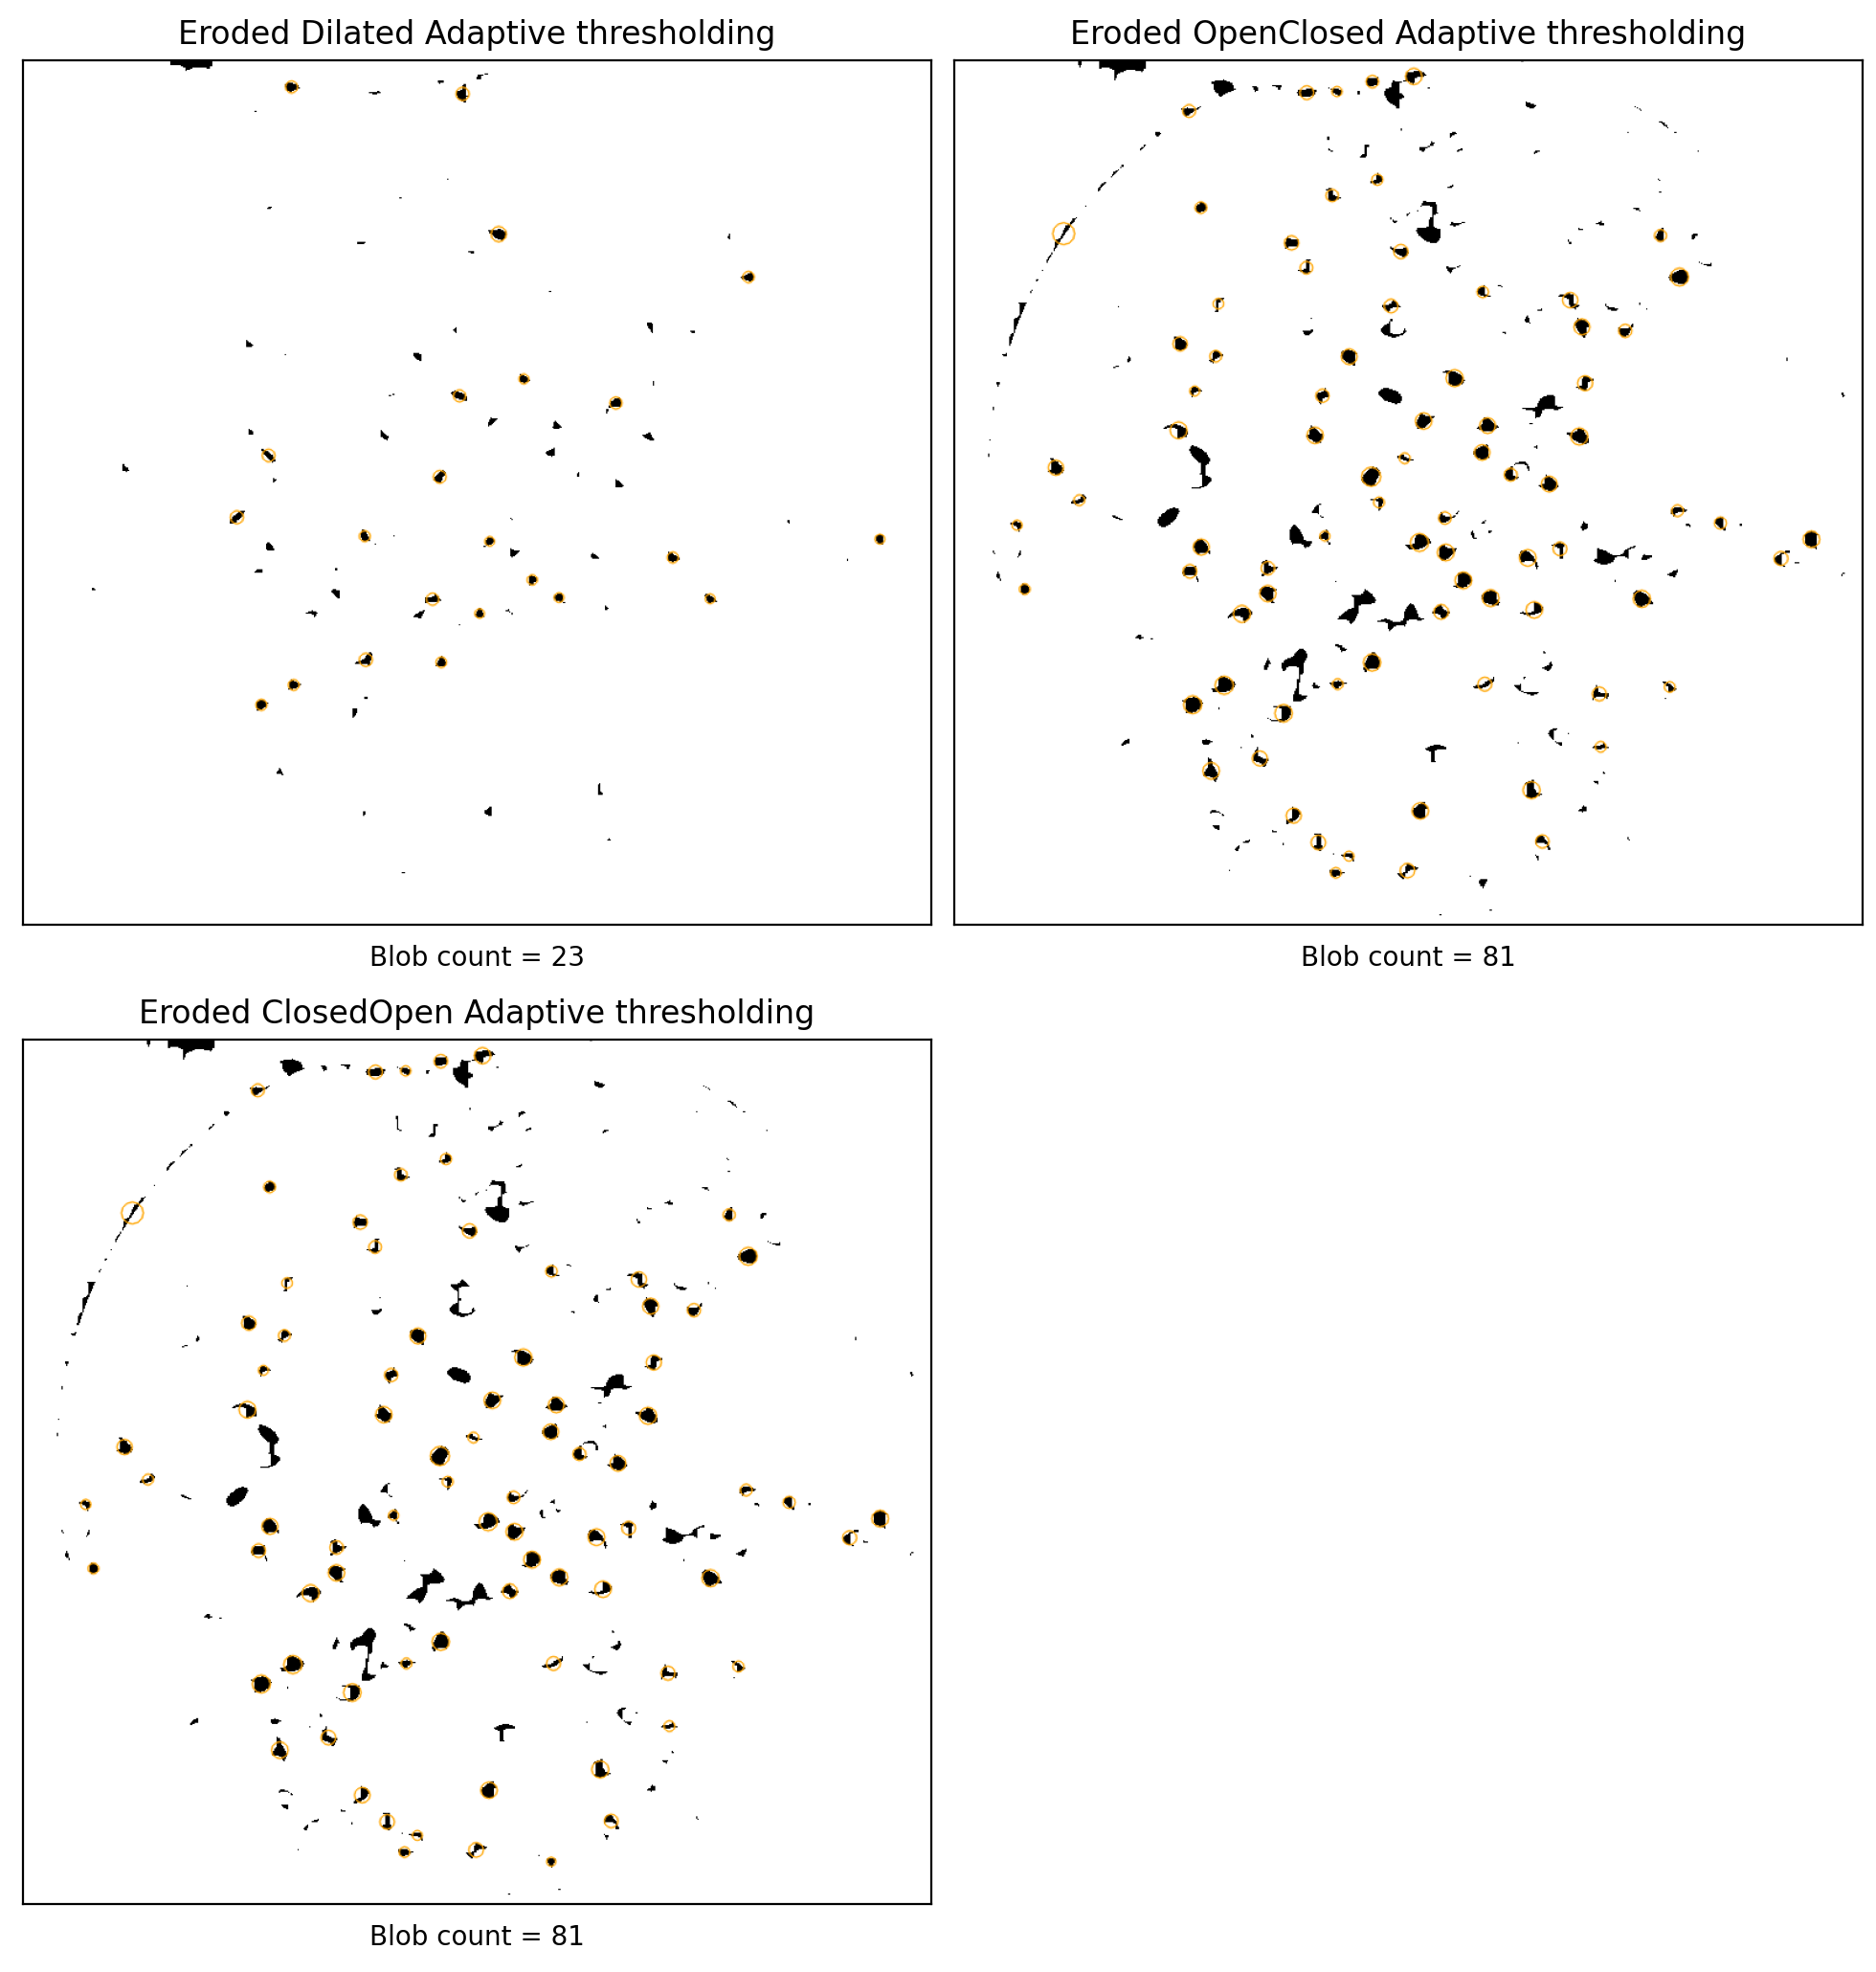

In [438]:
# images to process
images_to_detect = eroded_images
titles_to_detect = eroded_titles
# Turn on filters selected in the checkboxes above
filters = []
for i in range(0, len(checkboxes2)):
    filters = filters + [checkboxes2[i].value]
print('Filters on:')
print(filters)
params = cv2.SimpleBlobDetector_Params()
params.filterByArea, params.filterByCircularity, params.filterByConvexity, params.filterByInertia  = filters
###################################################################################################################
# SET PARAMETERS OF THE DETECTOR HERE
# # the main threshold is defined by the laplacian of each pixel, essentially seeing how drastic is the change in colour between the pixel and its neighbours
params.minThreshold = 10
params.maxThreshold = 500

# Filter by Area. In this case, there is no clear upper or lower limit - the area is defined in pixels and will depend strongly on your image resolution.
params.minArea = 50 # must be >0, but the min area will depend on image resolution
params.maxArea = 200 # must be >minArea, but the max area willwill depend on image resolution

# # Filter by Circularity: 1 - perfect circle, 0 - any shape
params.minCircularity = 0.01
params.maxCircularity = 1
#
# # Filter by Convexity 1 - perfectly convex, 0 - allows for many concave areas
params.minConvexity = 0.01 # can take values from 0 to 1
params.maxConvexity = 1 # can take values from minCovnexity to 1

# # Filter by Inertia - how long is elongated the is ellipse allowed to be
params.minInertiaRatio = 0.01 # can take values from 0 to 1
params.minInertiaRatio = 1 # can take values from minInertiaRatio to 1
# end of changable part
###################################################################################################################
# The code below creates a detector with the parameters we have set in this cell
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3:
    detector = cv2.SimpleBlobDetector(params)
else:
    detector = cv2.SimpleBlobDetector_create(params)
    
#  run the blob detection for all selected images
numCols = 2
numRows = math.ceil(len(images_to_detect)/numCols)
fig, axes =  plt.subplots(numRows, numCols, figsize=(width,width*aspect_ratio*numRows/numCols))
plt.ion()
#  loop over the images that were selected above and stored into the list
blobCounts = []
for iImage, image in enumerate(images_to_detect):   
    ax = axes.flatten()[iImage]
    image = 255-image
    keypoints = detector.detect(image)
    blank = np.zeros((1, 1)) #    blank = np.zeros((1, 1)) #
    im_with_keypoints = cv2.drawKeypoints(image, keypoints, blank, (255, 165, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax.imshow(im_with_keypoints)
    ax.set_title(titles_to_detect[iImage])
    ax.set_xlabel('Blob count = '+ str(len(keypoints)))
    blobCounts.append(len(keypoints))
    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
if iImage < numRows*2:
    for iEmptyImage in range(iImage+1,numRows*2):
        ax = axes.flatten()[iEmptyImage]
        fig.delaxes(ax)
plt.tight_layout(pad=0.5)
plt.show()

## In the end, we check how do detected blobs align with the original image

<IPython.core.display.Javascript object>


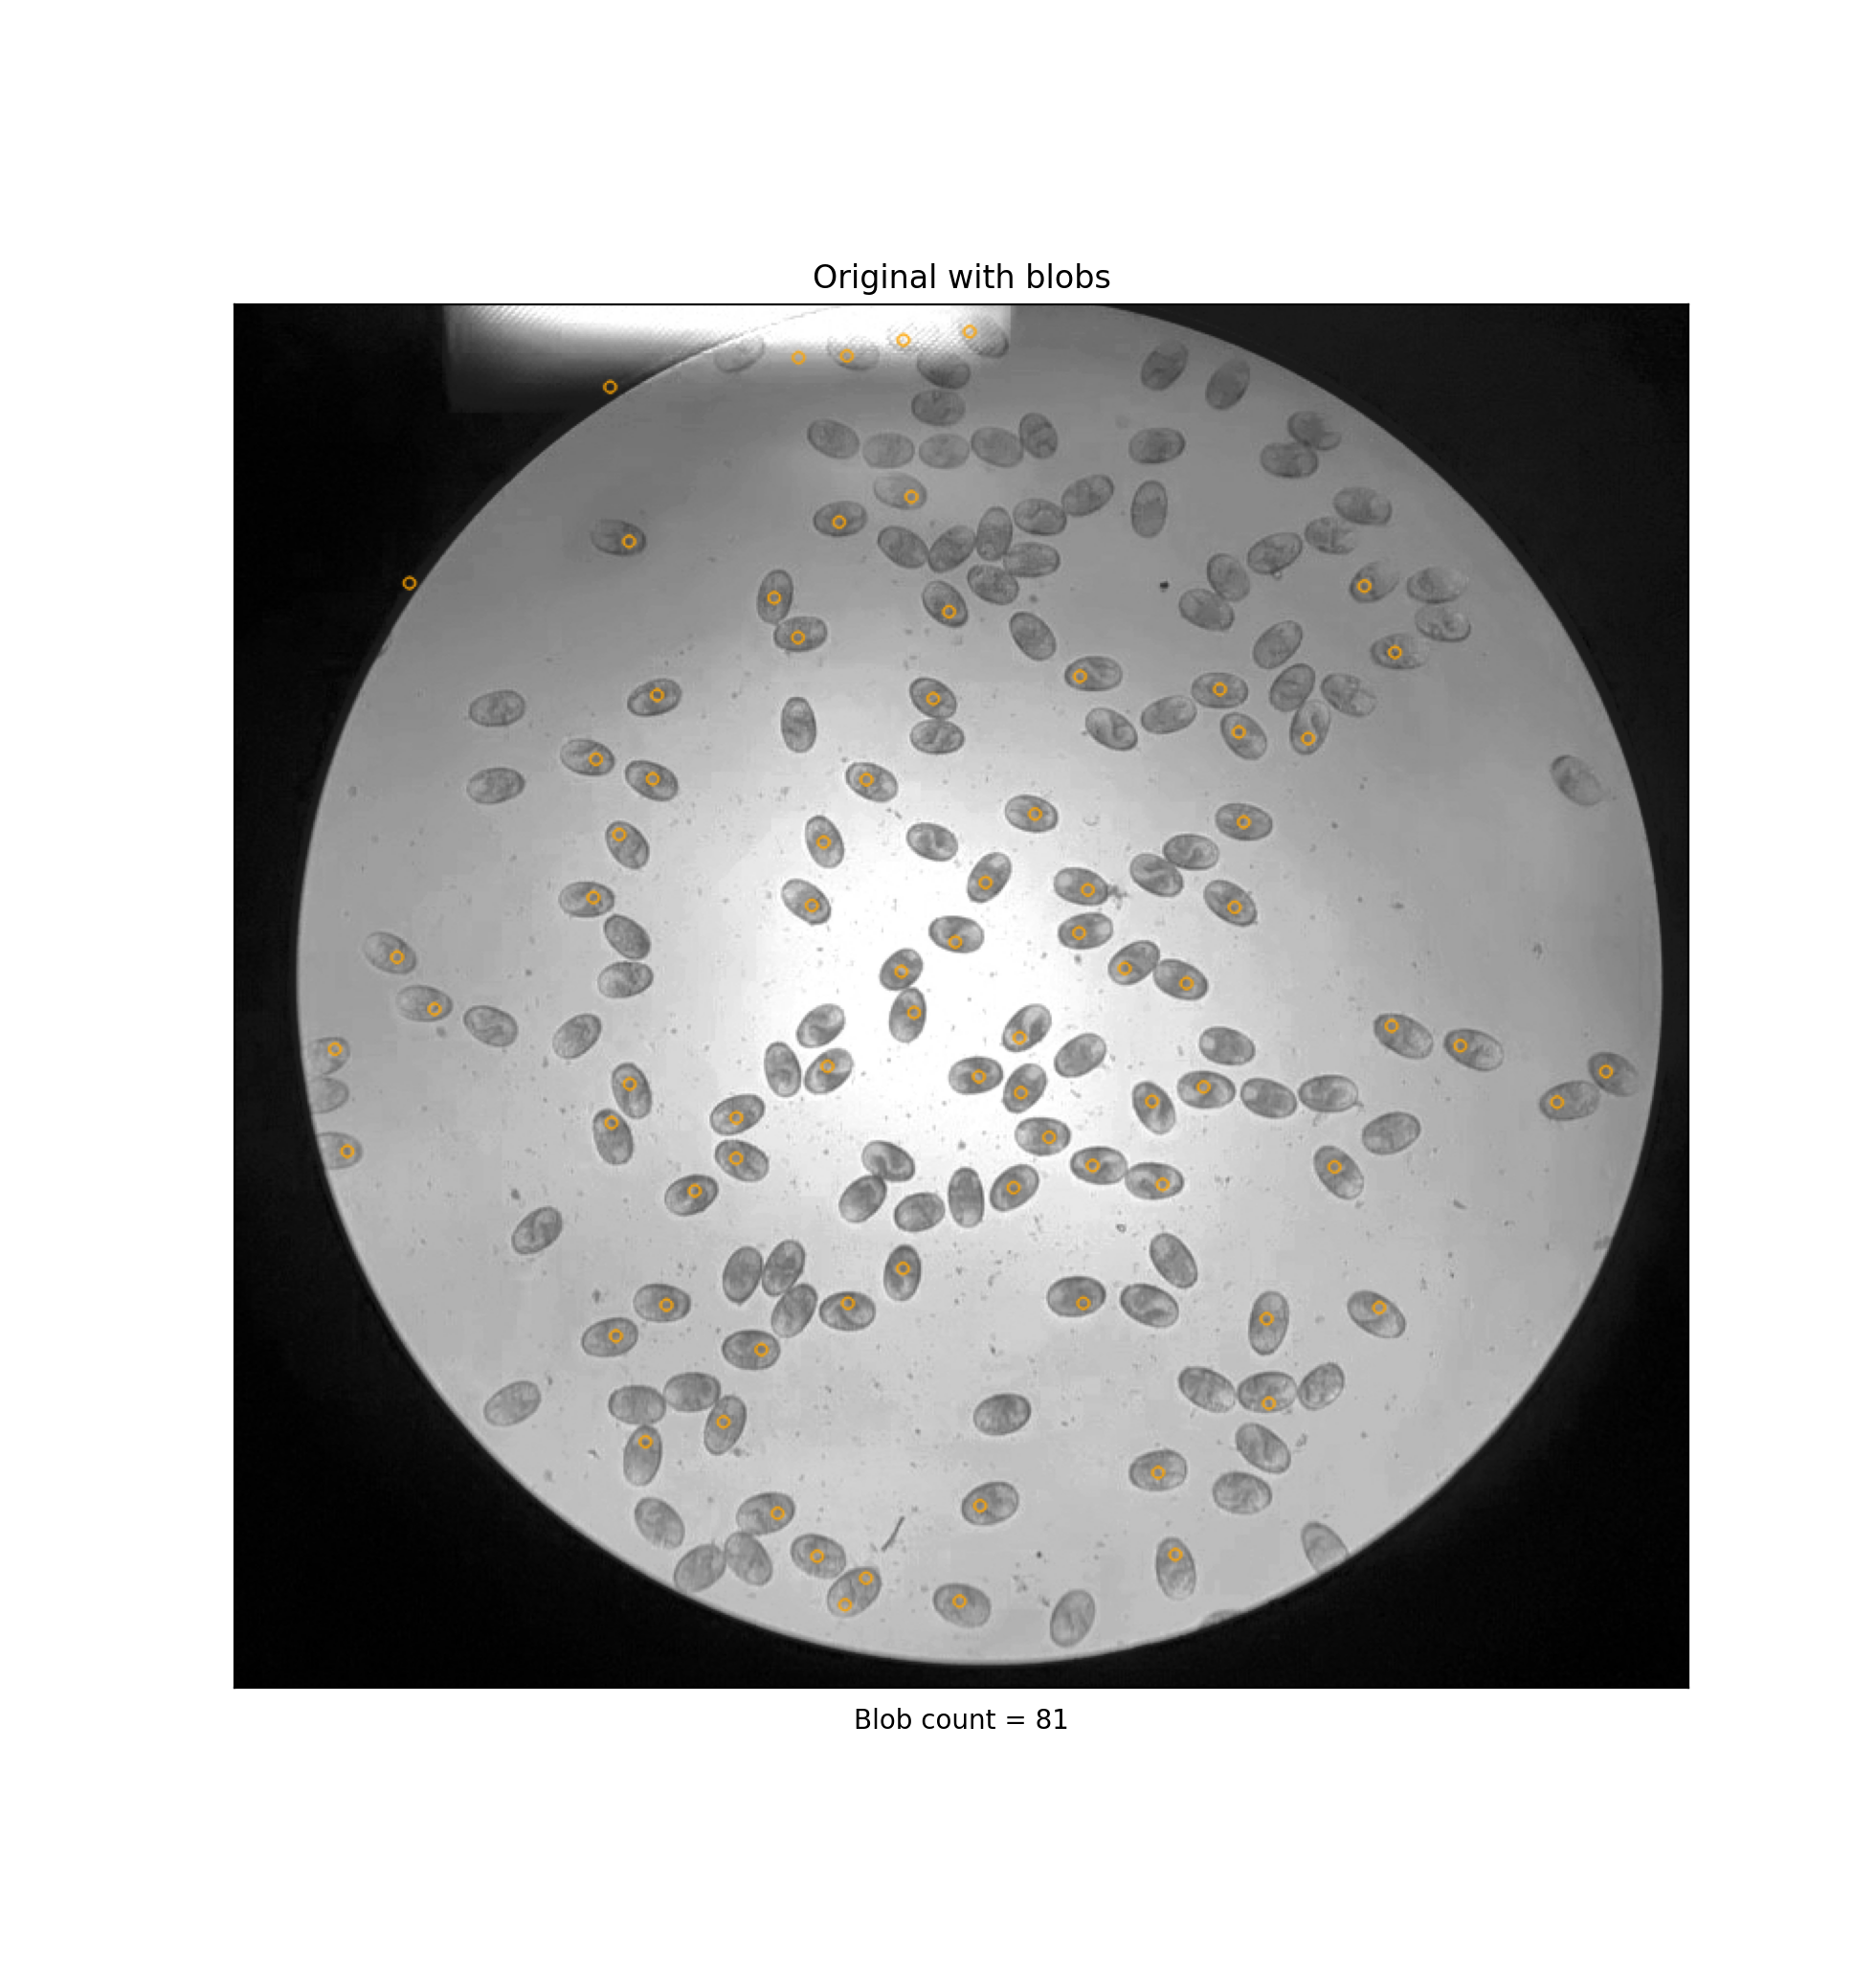

81


In [444]:
bestCountIndex = blobCounts.index(max(blobCounts))
fig = plt.figure(figsize=(width,width*aspect_ratio))
plt.subplot(111)
image = 255-images_to_detect[bestCountIndex]
keypoints = detector.detect(image)
blank = np.zeros((1, 1)) #    blank = np.zeros((1, 1)) #
im_with_keypoints = cv2.drawKeypoints(original, keypoints, blank, (255, 165, 0))
plt.imshow(im_with_keypoints)
plt.title('Original with blobs')
plt.xlabel('Blob count = '+ str(len(keypoints)))
# Hide X and Y axes tick marks
plt.xticks([])
plt.yticks([])
plt.show()